<a href="https://colab.research.google.com/github/ramachandra17/ramachandra17/blob/main/Rapids_GPU_ML_Workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#where, what, how?

Check the output of !nvidia-smi to make sure you've been allocated a Tesla T4, P4, or P100. Make sure you have selected the GPU in Runtime. I fyou don't get any mentioned GPU, then restart runtime and do it 2-3 times till you get GPU's T4,p$ or P100

In [ ]:
!nvidia-smi

Fri Sep 25 08:58:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Installing Rapids. This will take roughly 5 min or more. 
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable
# this is setting up miniconda envrionment on collab so that all dependent libraries for rpaid works
import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT CHANGES: RAPIDS on Colab will be pegged to 0.14 Stable until further notice.
2. Default stable version is now 0.14.  Nightly will redirect to 0.14.
3. You can now declare your RAPIDSAI version as a CLI option and skip the user prompts (ex: '0.14' or '0.15', between 0.13 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh s'
                  '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.15, or '!bash rapidsai-csp-utils/colab/rapids-colab.sh nightly', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh n'
Enjoy using RAPIDS!  

Make sure you get output like this towards the end of notebook 

************************************************
Your Google Colab instance has RAPIDS installed!
************************************************
***********************************************************************
Let us check on those pyarrow and cffi versions...
***********************************************************************

You're don't have pyarrow.
unloaded cffi 1.14.2
loaded cffi 1.11.5

In [ ]:
# load library
import cudf, cuml # these are dataframe library (like pandas) and ML library (like scikit) for GPU in Rapids
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, KFold
from cuml.neighbors import KNeighborsClassifier, NearestNeighbors # Importing KNN from Rapids cuML
import matplotlib.pyplot as plt
print('Checking CUML Version ',cuml.__version__)
print('Checking CUDF Version ',cudf.__version__)

Checking CUML Version  0.14.0+0.g31202da.dirty
Checking CUDF Version  0.14.0


Required Version:

Checking CUML Version  0.14.0+0.g31202da.dirty

Checking CUDF Version  0.14.0

In [ ]:
%%time
# reading through Pandas 
import pandas as pd
data_pandas = pd.read_csv("https://raw.githubusercontent.com/sbussmann/kaggle-mnist/master/Data/train.csv")

CPU times: user 2.3 s, sys: 452 ms, total: 2.75 s
Wall time: 3.7 s


In [ ]:
# Loading data with CuDF - GPU Data Frame 
%%time
train = cudf.read_csv('https://raw.githubusercontent.com/sbussmann/kaggle-mnist/master/Data/train.csv')

CPU times: user 1.49 s, sys: 639 ms, total: 2.13 s
Wall time: 2.86 s


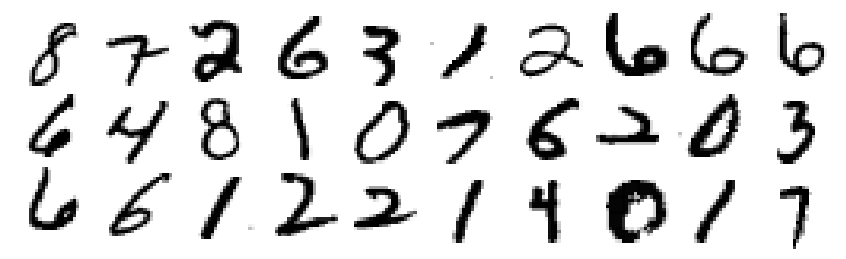

In [ ]:
# taking 30 sample from cuDF data frame and plotting them using matplotlib 
# There's a to_pandas function in cudf, which converts datafrom from cuDF to pandas DataFrame
# This convertion is important, since you can now do all things like visualization, EDA etc using pandas function. 
samples = train.iloc[5000:5030,1:].to_pandas().values
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(samples[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [ ]:
%%time
# First we will run the KNN Agorithm using cuML and see how much time it takes. 
# This experiments run KNN model for multiple K values
# This will be a good stress test to see why RAPIDS are powerfull. 
# we are running 19 experiments on ~40,000 dataset
from cuml.neighbors import KNeighborsClassifier, NearestNeighbors

X_train, X_test, y_train, y_test = train_test_split(train.iloc[:,1:], train.iloc[:,0],\
        test_size=0.2, random_state=42)

# GRID SEARCH FOR OPTIMAL K
accs = []
for k in range(3,22):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_hat_p = knn.predict_proba(X_test)
    # we are using predict_proba function tthat gives probability rather than class
    # Since we have taken probability, we will take max probability class using .argmax
    acc = (y_hat_p.to_pandas().values.argmax(axis=1)==y_test.to_array() ).sum()/y_test.shape[0]
    #print(k,acc)
    print(k,', ',end='')
    accs.append(acc)

3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , CPU times: user 5.34 s, sys: 3.68 s, total: 9.03 s
Wall time: 9.03 s


In [ ]:
%%time

# Now let's do the same experiment, but with Scikit Learn KNN Model 
# You would have to import the KNeighborsClassifier again from sklearn. Remember to re-import this from cuML later. 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Scikit Learn KNN Takes Huge time, so we are taking only 50% data and restricting it to run only one experiment. 
data_sample = data_pandas.sample(frac=0.5)
print(data_sample.shape)
X_train, X_test, y_train, y_test = train_test_split(data_sample.iloc[:,1:], data_sample.iloc[:,0],\
        test_size=0.2, random_state=42)

# GRID SEARCH FOR OPTIMAL K
accs = []
for k in range(3,4):
    print("Running for k - ",k)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_hat = knn.predict(X_test)
    acc = accuracy_score(y_test, y_hat)
    # print(k,', ',end='')
    accs.append(acc)

(21000, 785)
Running for k -  3
CPU times: user 2min 9s, sys: 97 ms, total: 2min 9s
Wall time: 2min 9s


As you can see, Scikit Learn model took ~2 min to just run one experiment and that too on 50% of data. That is very time consuming, given cuML KNN ran 19 experiments with full data of ~40k in under 10 sec. That's HUGE! 

In [ ]:
# Importing the KNeighborsClassifier again so that we use cuML version and not Scikit version
from cuml.neighbors import KNeighborsClassifier, NearestNeighbors

In [ ]:
%%time 
# Again, splitting into train and test 
# In this, we are going to increase the complexity of our experiments
# we will do 27 Experiemtns on K Value, but for each experiment, we will 5 Cross Validation, 
#That's total 135 experiments with ~40 K Data Poitns. 

X_train, X_test, y_train, y_test = train_test_split(train.iloc[:,1:], train.iloc[:,0],\
        test_size=0.2, random_state=42)


for k in range(3,30):
    print('Experimenting with k =',k)
    final_prediction = np.zeros(len(train))
    # Here we use scikit learn KFold function to help us split data
    # You can see that some scikit and pandas function work very well with RAPIDS 
    skf = KFold(n_splits=5, shuffle=True, random_state=42)
    # we are letting skf (KFOld object) decide the indexes for 5 split
    # for each split, we are running for loop and letting it fir the model 
    # It also prints the accuracy in each case, so that you can make choice. 
    for i, (index_train, index_test) in enumerate( skf.split(train.iloc[:,1:], train.iloc[:,0]) ):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(train.iloc[index_train,1:], train.iloc[index_train,0])
        # Better to use knn.predict() but cuML v0.11.0 has bug
        # y_hat = knn.predict(train.iloc[idxV,1:])
        y_hat_p = knn.predict_proba(train.iloc[index_test,1:])
        # to get accuracy, like previously, we are converting the predictions from cuDF to pandas
        # this conversion will help us use basic math caluclations using pandas. 
        final_prediction[index_test] =  y_hat_p.to_pandas().values.argmax(axis=1)
        acc = ( final_prediction[index_test]==train.iloc[index_test,0].to_array() ).sum()/len(index_test)
        print(' Cross Validated K fold Number =',i,'acc =',acc)
    acc = ( final_prediction==train.iloc[:,0].to_array() ).sum()/len(train)
    print(' Average Accuracy of 5 Folds with k =',k,'ACC =',acc)

Experimenting with k = 3
 Cross Validated K fold Number = 0 acc = 0.9666666666666667
 Cross Validated K fold Number = 1 acc = 0.9678571428571429
 Cross Validated K fold Number = 2 acc = 0.9641666666666666
 Cross Validated K fold Number = 3 acc = 0.9675
 Cross Validated K fold Number = 4 acc = 0.9704761904761905
 Average Accuracy of 5 Folds with k = 3 ACC = 0.9673333333333334
Experimenting with k = 4
 Cross Validated K fold Number = 0 acc = 0.9644047619047619
 Cross Validated K fold Number = 1 acc = 0.9665476190476191
 Cross Validated K fold Number = 2 acc = 0.9645238095238096
 Cross Validated K fold Number = 3 acc = 0.9666666666666667
 Cross Validated K fold Number = 4 acc = 0.969047619047619
 Average Accuracy of 5 Folds with k = 4 ACC = 0.9662380952380952
Experimenting with k = 5
 Cross Validated K fold Number = 0 acc = 0.9648809523809524
 Cross Validated K fold Number = 1 acc = 0.9671428571428572
 Cross Validated K fold Number = 2 acc = 0.9657142857142857
 Cross Validated K fold Numb

See the power of RAPIDS. It took roughly 1 min to run 135 experiments on 40k records. It would have taken more than hours on normal scikit learn on CPU. That's GPU power. 

In [ ]:
%%time 
# loading the test data for prediction using cuDF 
test = cudf.read_csv('https://raw.githubusercontent.com/sbussmann/kaggle-mnist/master/Data/test.csv')

CPU times: user 355 ms, sys: 37.6 ms, total: 392 ms
Wall time: 771 ms


In [ ]:
test.shape

(28000, 784)

In [ ]:
%%time
# Based on experiment, 5 K value seems to be optimized, so we are fitting final model for final test prediction
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train.iloc[:,1:785], train.iloc[:,0])

CPU times: user 133 ms, sys: 17 ms, total: 150 ms
Wall time: 151 ms


In [ ]:
%%time 
# Now we will use our perviously trained model, to do predcition on test data
y_hat_p = knn.predict_proba(test)
y_hat = y_hat_p.to_pandas().values.argmax(axis=1)

CPU times: user 277 ms, sys: 246 ms, total: 523 ms
Wall time: 528 ms


You can also see, how inference is so fast on GPU, it takes less than 600 milli seconds to prediction on 28000 records. Again, way better than scikit learn on CPU